## Modeling

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestClassifier, 
                                BaggingClassifier)

from nltk.stem.porter import *
from  nltk.stem import PorterStemmer

from sklearn.metrics import (precision_score,
                             f1_score,
                             recall_score,
                             accuracy_score,
                             confusion_matrix,
                             roc_curve,
                             auc)

from matplotlib import pyplot as plt


In [2]:
def metrics(model, X, y, tp, fn, tn, fp):
    y_pred = model.predict(X)
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print('Precision score: {}'.format(precision_score(y, y_pred)))
    print('Accuracy score: {}'.format(accuracy_score(y, y_pred)))
    print('F1-score score: {}'.format(f1_score(y, y_pred)))
    print('Sensivity score: {}'.format(recall_score(y, y_pred)))
    print('Specificity score: {}'.format(specificity))

In [3]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=73,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv,
                        n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, 
                                              s.mean(), 
                                              2 * s.std()))

In [4]:
# confusion matrix
def con_matrix(model, X, y):
    y_pred = model.predict(X)
    conmat = np.array(confusion_matrix(y, y_pred, labels=[1,0]))
    return pd.DataFrame(conmat, index=['not','hot'],
            columns=['predicted_not', 'predicted_hot'])

In [5]:
def roc_plot(model, X, y, title):
    y_proba = model.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=[8,8])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC for Hot Reddits ({})'.format(title), fontsize=16)
    plt.legend(loc="lower right")
    plt.savefig('../assets/{}.png'.format(title));

### Set up

In [6]:
# load data
reddits = pd.read_csv('../data/reddit_clean.csv')

In [7]:
# create target
med = reddits.num_comments.median()
reddits['num_comments'] = reddits.num_comments.apply(lambda x: 0 if x < med else 1)

In [8]:
# baseline 0.4914066954467704
1 - reddits.num_comments.mean()

0.4914066954467704

In [9]:
# stem the titles
stemmer = PorterStemmer()
reddits['title'] = reddits['title'].apply(lambda x: stemmer.stem(x))



In [10]:
## instantiate vectorizer
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(reddits.title)

TfidfVectorizer(max_df=0.6, max_features=200, stop_words='english',
                strip_accents='ascii')

In [11]:
# create vectorized dataframe
reddits_tvec = pd.DataFrame(tvec.transform(reddits.title).todense(),
                  columns = tvec.get_feature_names())

In [12]:
# concat vectorized and reddit dataframes
reddits_vect = pd.concat([reddits,reddits_tvec],axis=1)

In [49]:
# sums of hot words vs no hot words -- used to help select X features
reddits_greater = reddits_vect[reddits_vect.num_comments == 1].drop(['author', 
            'title','created', 'subreddit','num_comments',
            'score', 'upvote_ratio', 'length_time',
            'num_words', 'num_chars'], axis=1).sum().to_frame('count1')

reddits_lesser = reddits_vect[reddits_vect.num_comments == 0].drop(['author', 
            'title','created', 'subreddit','num_comments',
            'score', 'upvote_ratio', 'length_time',
            'num_words', 'num_chars'], axis=1).sum().to_frame('count0')

reddits_counts = pd.concat((reddits_greater, reddits_lesser), axis=1)
reddits_counts['diff'] = reddits_counts.count1 - reddits_counts.count0
reddits_counts.sort_values('diff', ascending=False).head()



,count1,count0,diff
new,132.289939,77.200755,55.089184
just,153.811444,102.749365,51.062079
going,45.664346,14.241357,31.422990
people,57.346394,27.334203,30.012191
game,51.139028,22.911737,28.227290


In [13]:
# instatiate X and y
X = reddits_vect[['upvote_ratio', 'length_time','score',
        'num_words', 'num_chars','depp','ukraine','school','police','gun',
        'amber','pride','man','2022','gun', 'new','year',
        'today','season','russian','hate','spoilers','free','buy',
        'actually','work','life','fuck','shares','dog']]

y = reddits_vect.num_comments.values

In [14]:
# set up train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=.2,
                                                   random_state=73)

In [15]:
# standard scale the data
ss = StandardScaler()
ss.fit(X_train, y_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

### Logistic regression

In [16]:
lr = LogisticRegression(solver='liblinear',
                       C=100,
                       penalty='l2',
                       random_state=73
                       )

lr.fit(X_train_scaled, y_train)

LogisticRegression(C=100, random_state=73, solver='liblinear')

In [17]:
{feature: importance for feature, importance in zip(X.columns, lr.coef_[0])}

{'upvote_ratio': -0.8200078093629014,
 'length_time': 0.037374653965033616,
 'score': 1.1847514620218527,
 'num_words': -0.15905613886752923,
 'num_chars': 0.5820866875975181,
 'depp': 0.02376532202642255,
 'ukraine': 0.025079298493961902,
 'school': -0.017781221086861875,
 'police': 0.08318714657745559,
 'gun': 0.03572871268253524,
 'amber': -0.0502452578088268,
 'pride': 0.005304837464581517,
 'man': 0.023461874181591316,
 '2022': 0.06954974540478347,
 'new': 0.0937394803510012,
 'year': 0.007299862267006491,
 'today': 0.04484441774217166,
 'season': 0.04724800239352754,
 'russian': 0.05104949487184429,
 'hate': 0.0005871279164043875,
 'spoilers': 0.043761240930669854,
 'free': 0.031950790964534015,
 'buy': 0.029685066997337747,
 'actually': 0.02091103737654615,
 'work': -0.025178602061530126,
 'life': -0.008187911199944876,
 'fuck': 0.018793675599167864,
 'shares': -0.06415604386819763,
 'dog': -0.07304261419609813}

- an increase in one standard deviation `school` is associated with 0.9823759319883832 decrease in the odds of a hot post


- an increase in one standard deviation `num_words` is associated with 0.8529484740636472 decrease in the odds of a hot post


- an increase in one standard deviation `year` is associated with 1.007326571212552 increase in the odds of a hot post


- an increase in one standard deviation `pride` is associated with 1.0053189330287142 increase in the odds of a hot post


- an increase in one standard deviation `hate` is associated with 1.052374979158927 increase in the odds of a hot post


- an increase in one standard deviation `hate` is associated with 1.0301300609093489 increase in the odds of a hot post

In [18]:
# score X_train
score(lr, 'Logistic regression', X_train_scaled, y_train)

Logistic regression Score: 0.72 +- 0.033


In [19]:
# score X_test
score(lr, 'Logistic regression', X_test_scaled, y_test)

Logistic regression Score: 0.71 +- 0.051


The logistic regression on both train and test data outperform the baseline (0.49) significantly, with small confidence intervals. There is a minimal drop in the r-squared score between train and test data.  

In [20]:
# confusion matrix
con_matrix(lr, X_test_scaled, y_test)

,predicted_not,predicted_hot
not,823,444
hot,268,921


The true positives and true negatives out-number the false positives and false negatives.  Of most concern, is the false negatives (444), which should ideally be smaller in number.

In [21]:
# metrics
metrics(lr, X_test_scaled, y_test, 823, 444, 921, 268)


Precision score: 0.7543538038496792
Accuracy score: 0.7100977198697068
F1-score score: 0.6980491942324004
Sensivity score: 0.6495659037095501
Specificity score: 0.7746005046257359


The precision score indicates that the proportion of that which was correctly classified as positive is high, and the overall accuracy is slightly lower.  The recall (sensitivity) score indicates that the number of correctly made positive predictions (out of the total positive predictions) is moderate, while the specificity score for correctly predicting true negatives is a lot higher.  and the f1-score, measuring the model's accuracy is also moderate.

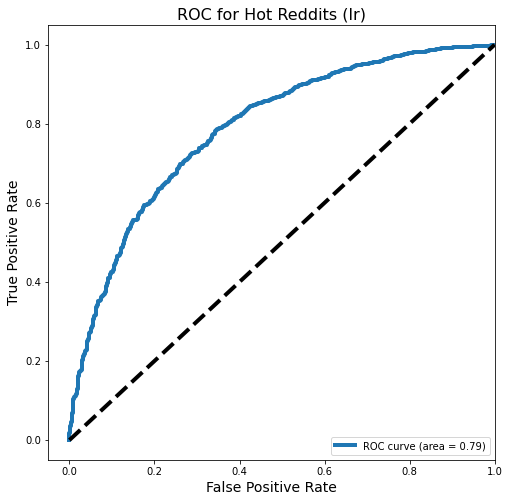

In [22]:
# plot roc
roc_plot(lr, X_test_scaled, y_test, 'lr')

As indicated on the ROC plot, the model outperforms the baseline by a decent margin.  The ROC score is considered acceptable. 

### Random forest

In [23]:
# instantiate and fit
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=73,
                            n_estimators=200,
                            min_samples_leaf=5,
                            warm_start=True)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=-1,
                       random_state=73, warm_start=True)

In [24]:
{feature: importance for feature, importance in zip(X.columns, rf.feature_importances_)}


{'upvote_ratio': 0.23528626712352754,
 'length_time': 0.10172738540578333,
 'score': 0.4363718309016246,
 'num_words': 0.0765815835550457,
 'num_chars': 0.11481711240216437,
 'depp': 0.0005823155990702432,
 'ukraine': 0.001324530371884356,
 'school': 0.0008301530682723648,
 'police': 0.0010943493514333083,
 'gun': 0.000939409071066473,
 'amber': 0.00012133646524194457,
 'pride': 0.0018123562009260176,
 'man': 0.0016838323064131563,
 '2022': 0.0026052037432580132,
 'new': 0.006381759493091786,
 'year': 0.001769152357666276,
 'today': 0.0027336707685421853,
 'season': 0.0011652846484907458,
 'russian': 0.0011045739943752223,
 'hate': 0.0003085585958907999,
 'spoilers': 0.001691676413513379,
 'free': 0.0004959005734055888,
 'buy': 0.00042075119094292025,
 'actually': 0.00043968672318447786,
 'work': 0.0016181335887222614,
 'life': 0.000765416303870197,
 'fuck': 0.0001897720658317611,
 'shares': 0.0014720049656773578,
 'dog': 0.0023614073465922734}

In terms of feature importance, the top features seem to be related to the reddit scrape, e.g score, upvote_ratio, number of characters, length of time, and so forth.  The top vectorized words are:  'new', 'today', '2022', 'dog', and 'pride'.

In [25]:
# score the X_train
score(rf, 'Random forest', X_train, y_train)

Random forest Score: 0.74 +- 0.031


In [26]:
# score the X_test
score(rf, 'Random forest', X_test, y_test)

Random forest Score: 0.71 +- 0.033


The random forest on both train and test data outperform the baseline (0.49) significantly, with small confidence intervals. While random forest performed better than the logistic regression in the training data, there is a 3% drop in the r-squared score between train and test data.  The scores on the training data are marginally improved over the scores for the training data in the logistic regression.  

In [27]:
# confusion matrix
con_matrix(rf, X_test, y_test)

,predicted_not,predicted_hot
not,926,341
hot,307,882


The true positives and true negatives out-number the false positives and false negatives.  The random forest model has more true positives than the logistic regression, but less true negatives.  The false negative values are better in random forest, however the false positives are higher than that of the logistic regression.

In [28]:
# metrics
metrics(rf, X_test, y_test, 926, 341, 882, 307)

Precision score: 0.7510137875101379
Accuracy score: 0.7361563517915309
F1-score score: 0.7408
Sensivity score: 0.7308602999210734
Specificity score: 0.7417998317914214


The precision score measuring the the proportion of that which was classified positive correctly, is slightly lower in this model as compared to the logistical regression model, but the overall accuracy is higher.  However, the sensivity and f1-scores are higher in the random forest model. Note that specificity is higher in the logistic regression.

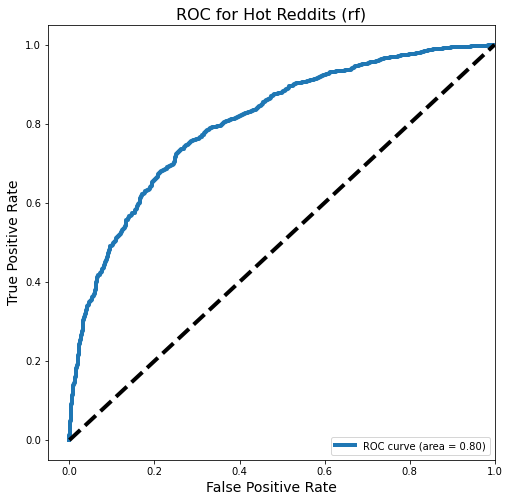

In [29]:
# plot roc
roc_plot(rf, X_test, y_test, 'rf')

As indicated on the ROC plot, the model outperforms the baseline by a decent margin.  The ROC score is considered acceptable. The random forest ROC score is slightly higher than the logistic regression ROC score. 

### Bagging

In [30]:
# instantiate 
dt = DecisionTreeClassifier(random_state=73,
                            class_weight='balanced',)
bdt = BaggingClassifier(dt,
                        random_state=73,
                        n_jobs=-1,
                        n_estimators=200)

bdt.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        random_state=73),
                  n_estimators=200, n_jobs=-1, random_state=73)

In [31]:
# https://stackoverflow.com/questions/44333573/feature-importances-bagging-scikit-learn

feature_importances = np.mean([
    tree.feature_importances_ for tree in bdt.estimators_
], axis=0)

{feature: importance for feature, importance in zip(X.columns, 
                            feature_importances)}



{'upvote_ratio': 0.13466007407834174,
 'length_time': 0.2003537819746975,
 'score': 0.36833394887951326,
 'num_words': 0.07415536338807537,
 'num_chars': 0.16858096447205173,
 'depp': 0.0012918630911318897,
 'ukraine': 0.0019523196876884248,
 'school': 0.0016235509244028514,
 'police': 0.0005505709592295933,
 'gun': 0.0007448192989551651,
 'amber': 0.001140572326407654,
 'pride': 0.0031629922612237556,
 'man': 0.002915435426367255,
 '2022': 0.003879305848006841,
 'new': 0.007617446712973752,
 'year': 0.0032729080608757,
 'today': 0.0046171257418472465,
 'season': 0.0026165907978393937,
 'russian': 0.0009036868055837397,
 'hate': 0.0009789230933973045,
 'spoilers': 0.0017118654808965387,
 'free': 0.0012618707317949781,
 'buy': 0.0021338916389137415,
 'actually': 0.0011097705978480932,
 'work': 0.002464927665205185,
 'life': 0.0018605697658369324,
 'fuck': 0.0011046700948986509,
 'shares': 0.0018591971343808033,
 'dog': 0.0023794892692384395}

Similarly to the random forest, the top important features come from webscraping features such as score and upvote ratio.  In terms of vectorized words, the most popular are:  'new', 'today', '2022', 'year' and 'pride'.

In [32]:
# score X_train
score(bdt, 'Bagging', X_train, y_train)

Bagging Score: 0.71 +- 0.028


In [33]:
# score X_test
score(bdt, 'Bagging', X_test, y_test)

Bagging Score: 0.71 +- 0.033


The bagging model on both train and test data outperform the baseline (0.49) significantly, with small confidence intervals. The bagging model has the worst performing training r-squared scores, while the r-squared scores for testing data are about comparable to the r-squared scores of the random forest test scores. 

In [34]:
# confusion matrix
con_matrix(bdt, X_test, y_test)

,predicted_not,predicted_hot
not,900,367
hot,337,852


The true positives and true negatives are higher than the false negatives and false positives.  The true positives in bagging outperform the true positives in the logistic regression (but not the random forest model), however the true negatives perform worse than the logistic and random forest models.  The false positives and false negatives are worse in this model than the random forest model.  

In [35]:
# metrics
metrics(bdt, X_test, y_test, 900, 367, 852, 337)

Precision score: 0.7275666936135813
Accuracy score: 0.7133550488599348
F1-score score: 0.7188498402555911
Sensivity score: 0.7103393843725335
Specificity score: 0.7165685449957948


The precision score in the bagging model is lower than the precision scores for the random forest and logistic models, respectively, and the accuracy score is higher than logistic regression, but lower than random forest.  The sensitivy score is better than the logistic regression model, but worse than the random forest model.  The same is true of the f1-score: it peforms worse compared to the random forest model, but better than the logistic regression model. The specificity score is worse in this model than the other two.

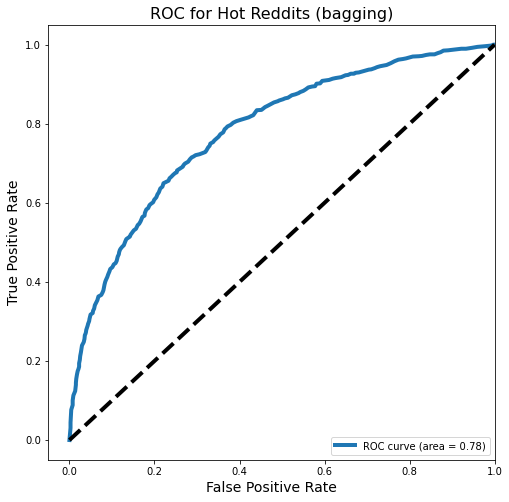

In [36]:
# plot roc
roc_plot(bdt, X_test, y_test, 'bagging')

As indicated on the ROC plot, the model outperforms the baseline by a decent margin.  The ROC score is considered acceptable. The bagging ROC score is slightly lower than bogth the random forest and logistic regression models. 

### Conclusions

The models all had varying results in terms of the weight given to words that impacted the modeling.  The logistic regression model favored words such as 'hate', 'pride', 'actually' and 'year'.  The random forest model favored words such as 'upvote_ratio', 'num_chars', 'new', 'pride', and 'dog'.  The bagging model favored words such as 'upvote_ratio', 'new', 'year', 'pride', and '2022'. 'Pride' was common to all three models, while 'year' was common to the bagging and the logistic regression models.  

When selecting words to pass into the model, there were certain words that increased the scores.  Newsworthy words such as 'ukraine' and 'depp' tended to boost the scores.  Topical words such as '2022' and 'pride' also helped increase the scores.  Interestingly enough, 'dog' increased the scores, whilst 'cat' decreased them.  The biggest predictive power by far came from the reddit score, which is the popularity of a reddit post (as measured by number of upvotes).  Words such as 'spoiler' and 'season' also seemed to boost the scores. 

In addition, when looking at popular subreddits, political-themed subreddits proved to be very popular (as measured by the numbers of comments).  This aligns with what I found when tuning the model: words that reflected the "news of the day" proved to be effective predictors.  

As far as models go, random forest generally performed better than the other two models (logistic and bagging).  It allowed the most tuning of the r-squared score, continually improving the scores whereas the other models hit a point of diminishing returns. It also had the best training scores of all three models (though it should be noted that it tied with the bagging model for test data scores).  

In terms of metrics, the random forest model had the best overall accuracy score, as well as the best sensitivity and f1-scores.  The logistic regression model, on the other hand, had the best precision and specificity scores. The bagging model performed the worst of the three.  

My recommendation, therefore, is to use the random forest model.  In terms of what characteristics have the most predictive power for overall interaction, as mentioned above, political and newsworthy terms seemed to effective predictors.  Reddits about Ukraine, the school shooting, and the Depp/Heard defamation suit were all good predictors, as well as temporal words like 'time', 'year', '2020', and 'today.  Finally, words related to the entertainment medium such as 'spoiler' and 'season' seemed to be good predictors too.